In [14]:
# ! pip install hyperopt

In [15]:
from ricatti_observer_class import riccati_observer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as pytime
from hyperopt import hp, fmin, tpe, space_eval
name = "trial6"



In [44]:
use_adaptive            = True
quaternion              = True
time                    = (0, 50)
stepsize                = 0.1
tol                     = 1e-2 * 3
noise                   = False
which_eq                = 2
which_omega             = "full" # "z" or "full"
with_image_hz_sim       = False
image_hz                = 60
randomize_image_input   = False
p_hat                   = np.array([[-2, 4, 3]], dtype=np.float64).T
Lambda_bar_0            = np.array([np.sqrt(2)/2, np.sqrt(2)/2, 0, 0]).T  # quaternion: w, x, y, z
z_appear                = np.array([[[2.5, 2.5, 0]], [[5, 0, 0]], [[0, 0, 0]]])
p_ricatti               = np.array([1, 100])

In [32]:
def objective(args): # can also set different case
    current_time = 0
    total_error_p = 0
    total_error_r = 0
    count = 0
    k, q, v1, v2 = args # argument that need to be tuned
    start_time = pytime.time()
    riccati_obj = riccati_observer(
        use_adaptive            = use_adaptive,
        quaternion              = quaternion,
        time                    = time,
        stepsize                = stepsize,
        tol                     = tol,
        noise                   = noise,
        which_eq                = which_eq,
        which_omega             = which_omega, # "z" or "full"
        with_image_hz_sim       = with_image_hz_sim,
        image_hz                = image_hz, 
        randomize_image_input   = randomize_image_input,
        p_hat                   = p_hat,
        Lambda_bar_0            = Lambda_bar_0,  # quaternion: w, x, y, z
        z_appear                = z_appear,
        k                       = k,
        q                       = [q], 
        v                       = np.array([v1, v2]),
        p_ricatti               = p_ricatti
        )
    while current_time <= riccati_obj.time[1]:
        current_time, dt_step, soly = riccati_obj.step_simulation()
        Actual_R = riccati_obj.rodrigues_formula(soly[:4])
        Estimate_R = riccati_obj.rodrigues_formula(soly[4:8])
        Estimate_p_bar = soly[8:11]
        Actual_p = np.array([2.5+2.5*np.cos(0.4*current_time), 2.5*np.sin(0.4*current_time), 10])
        Actual_p_bar = np.matmul(np.transpose(np.array(Actual_R).reshape((3,3))), Actual_p)
        # p_temp = np.matmul(np.array(Estimate_R).reshape((3,3)), Estimate_p_bar)
        error_p = Actual_p_bar - Estimate_p_bar
        squared_error_p = np.dot(error_p.T, error_p)
        total_error_p += squared_error_p

        error_r = soly[:4] - soly[4:8]
        squared_error_r = np.dot(error_r.T, error_r)
        total_error_r += squared_error_r

        count += 1
    compute_time = (pytime.time() - start_time)
    error_weight_p = 0.8
    error_weight_r = 0.8
    time_weight = 0.4
    final_error_p = error_weight_p/(error_weight_p + time_weight + error_weight_r) * (total_error_p/count) 
    fianl_error_r = error_weight_r/(error_weight_p + time_weight + error_weight_r) * (total_error_r/count)
    final_error_time = time_weight/(error_weight_p + time_weight + error_weight_r) * (compute_time/riccati_obj.time[1])
    score = final_error_p + final_error_time + fianl_error_r
    print(count)
    print(total_error_p, total_error_p/count)
    print(total_error_r, total_error_r/count)
    print(compute_time, compute_time/riccati_obj.time[1])
    return score

space = (hp.uniform('k', 1, 30),
         hp.uniform('q', 0, 10),
         hp.uniform('v1', 0, 10),
         hp.uniform('v2', 0, 10))

# minimize the objective over the space
best = fmin(objective, space, algo=tpe.suggest, max_evals=1)

print(best)
print(space_eval(space, best))

18391                                                
9201.376938162997                                    
0.5003195551173398                                   
16974.004950389368                                   
0.9229517128154732                                   
54.57291030883789                                    
1.0914582061767577                                   
100%|██████████| 1/1 [00:54<00:00, 54.59s/trial, best loss: 0.7876001484084768]
{'k': 25.57667956044601, 'q': 9.194603969969204, 'v1': 5.705010325333645, 'v2': 1.3583132323290426}
(25.57667956044601, 9.194603969969204, 5.705010325333645, 1.3583132323290426)


In [45]:
riccati_obj = riccati_observer(
    use_adaptive            = use_adaptive,
    quaternion              = quaternion,
    time                    = (0, 100),
    stepsize                = stepsize,
    tol                     = tol,
    noise                   = noise,
    which_eq                = which_eq,
    which_omega             = which_omega, # "z" or "full"
    with_image_hz_sim       = with_image_hz_sim,
    image_hz                = image_hz, 
    randomize_image_input   = randomize_image_input,
    p_hat                   = p_hat,
    Lambda_bar_0            = Lambda_bar_0,  # quaternion: w, x, y, z
    z_appear                = z_appear,
    k                       = 1, #best['k'],
    q                       = [10], #[best['q']], 
    v                       = np.array([0.1, 1]), #np.array([best['v1'], best['v2']]),
    p_ricatti               = p_ricatti
    )

In [46]:
riccati_obj.full_simulation()

Simulation time: 99.99866064454397      Run time: 149.777563810348563606



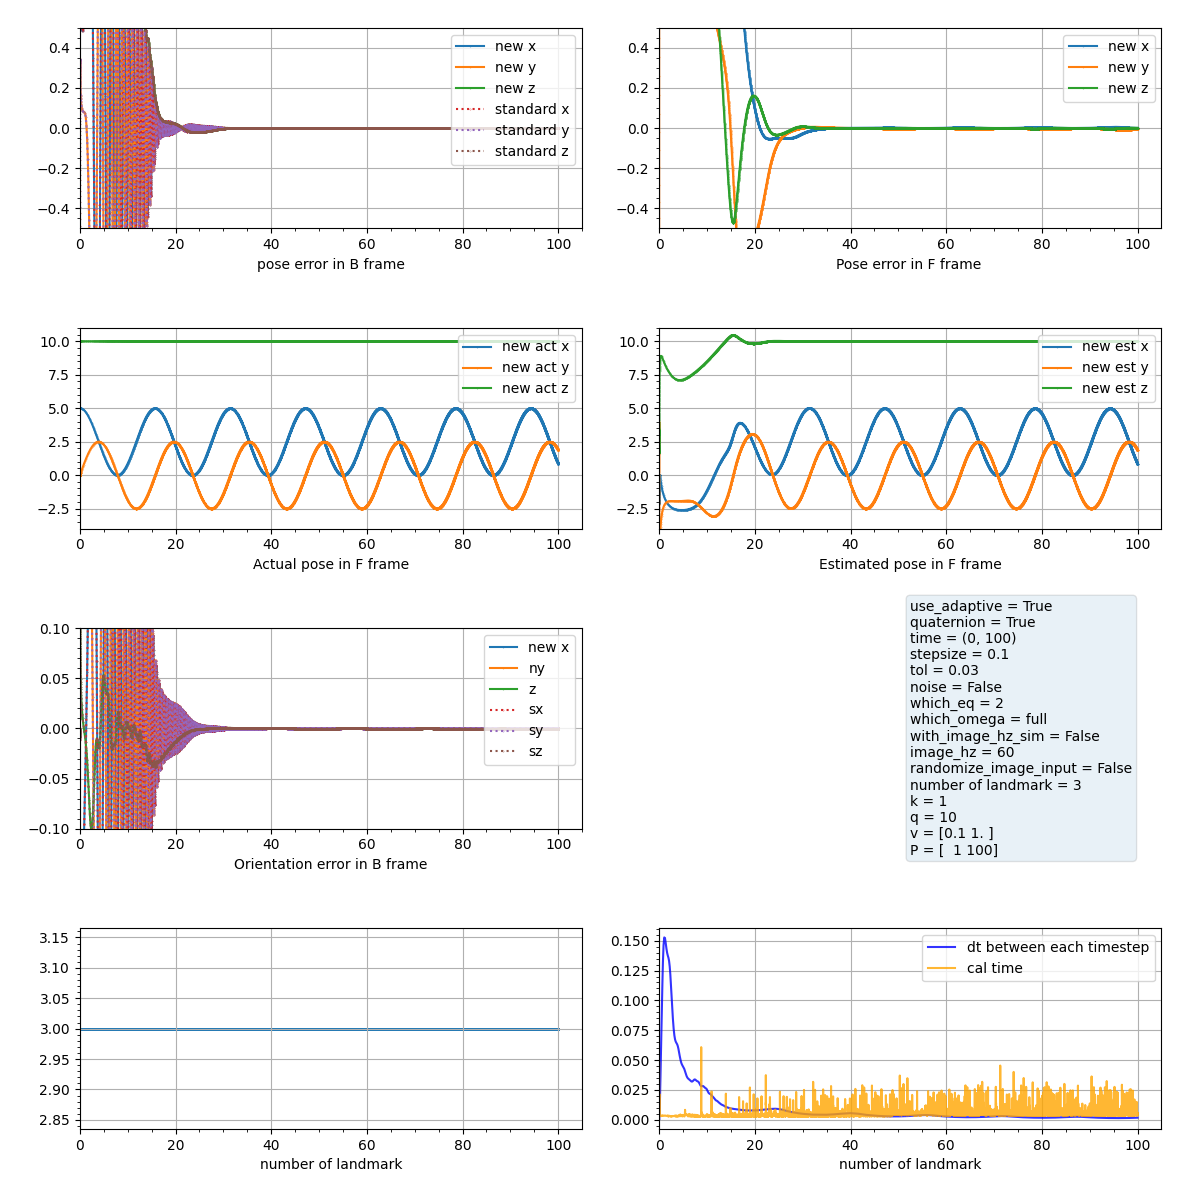

In [47]:
%matplotlib widget
fig, ax = riccati_obj.visual_plot(figsize=(12,12), bound_y=True)  

In [48]:
# fig.suptitle("Example Plot")
name = "2_full"
fig.savefig("/home/annika/ITRL/kth_thesis/simulated_result/" + name + ".png")
# fig.savefig("/home/annika/ITRL/kth_thesis/simulated_result/parameter_opt/" + name + ".png")
# name = str(riccati_obj.which_eq) + "_" + str(riccati_obj.which_omega)
# my_solutiony = np.transpose(np.array(riccati_obj.soly))
# my_solutiont = np.hstack((riccati_obj.solt, riccati_obj.time[1]))
# df = pd.DataFrame(np.vstack((my_solutiony, my_solutiont)).flatten())
# df.to_csv('/home/annika/ITRL/kth_thesis/simulated_result/' + name + '.txt', sep='\t', index=False, header=False)